<a href="https://colab.research.google.com/github/PatilTanmay512/MSc-Project/blob/main/MscProjecT_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score,f1_score, confusion_matrix , plot_confusion_matrix , accuracy_score , precision_score , recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier 
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
import pickle
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pd.options.mode.chained_assignment = None  
pd.options.display.max_rows = 200
pd.options.display.max_columns = 150
sns.set_theme()

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Loan_data',low_memory=False)

In [ ]:
data = data.drop(['Unnamed: 0','member_id'],axis = 1)

In [ ]:
data.loan_status.value_counts()

Fully Paid                                             702354
Charged Off                                            268559
Late (31-120 days)                                      21467
In Grace Period                                          8436
Late (16-30 days)                                        4349
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    40
Name: loan_status, dtype: int64

In [ ]:
Loan_Main = data.copy()

In [ ]:
Loan_Main['loan_status'] =  np.where(Loan_Main['loan_status'].str.contains('Fully'),0,1)

In [ ]:
Loan_Main.loan_status.value_counts()

0    704375
1    303612
Name: loan_status, dtype: int64

In [ ]:
def emp_to_num(term):
    if pd.isna(term):
        return None
    elif term[2]=='+':
        return 10
    elif term[0]=='<':
        return 0
    else:
        return int(term[0])

Loan_Main['emp_length'] = Loan_Main['emp_length'].apply(emp_to_num)

In [ ]:
nunique_val = Loan_Main.apply(pd.Series.nunique)
single_val_cols = nunique_val[nunique_val == 1].index.tolist()
single_val_cols

['policy_code', 'hardship_type', 'deferral_term', 'hardship_length']

In [ ]:
Loan_Main= Loan_Main.drop(single_val_cols, axis =1)

In [ ]:
a=Loan_Main.isnull().sum()/len(Loan_Main)*100
variables = Loan_Main.columns
len(variables)

145

In [ ]:
variable = [ ]
for i in range(0,len(variables)):
    if a[i]<50: 
        variable.append(variables[i])
 
drop_columns1=list(set(variables) - set(variable))
df_drop_nan=Loan_Main.drop(columns=drop_columns1)

In [ ]:
((df_drop_nan.isnull().sum()/len(df_drop_nan))*100).sort_values(ascending=False)

mths_since_recent_inq         13.839663
num_tl_120dpd_2m              10.542894
mo_sin_old_il_acct             9.771455
pct_tl_nvr_dlq                 6.990368
avg_cur_bal                    6.977372
mo_sin_rcnt_rev_tl_op          6.975288
mo_sin_old_rev_tl_op           6.975288
num_rev_accts                  6.975189
num_tl_30dpd                   6.975189
num_il_tl                      6.975189
num_bc_tl                      6.975189
num_rev_tl_bal_gt_0            6.975189
tot_coll_amt                   6.975189
tot_cur_bal                    6.975189
total_rev_hi_lim               6.975189
num_actv_rev_tl                6.975189
num_tl_90g_dpd_24m             6.975189
num_op_rev_tl                  6.975189
num_tl_op_past_12m             6.975189
num_actv_bc_tl                 6.975189
num_accts_ever_120_pd          6.975189
tot_hi_cred_lim                6.975189
total_il_high_credit_limit     6.975189
mo_sin_rcnt_tl                 6.975189
emp_title                      6.730940


***Since we don't have a clear understanding for many features, it would be unwise to include them into our analysis without truly understanding a feature. \ Moreover, not all features will be available to us before a person gets loan. \ Some features will only be available after a person gets a loan. We have the following features we will be proceeding with the given features ***

In [ ]:
final_features = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
                          'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
                          'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',"addr_state",
                          'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
                          'revol_util', 'total_acc', 'initial_list_status', 'application_type',
                          'mort_acc', 'pub_rec_bankruptcies','fico_range_low','fico_range_high']

In [ ]:
df = df_drop_nan[final_features]

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amnt,1007954.0,14548.746471,8773.824100,500.00,8000.00,12000.00,20000.00,40000.00
int_rate,1007954.0,13.807262,4.861595,5.31,10.49,13.35,16.59,30.99
installment,1007954.0,442.178182,263.362785,4.93,251.55,378.22,584.96,1719.83
emp_length,947757.0,5.946822,3.683302,0.00,2.00,6.00,10.00,10.00
annual_inc,1007950.0,75607.791317,68894.605344,0.00,45000.00,65000.00,90000.00,9573072.00
loan_status,1007987.0,0.301206,0.458782,0.00,0.00,0.00,1.00,1.00
dti,1007660.0,18.284156,11.142748,-1.00,11.80,17.63,24.04,999.00
open_acc,1007925.0,11.538216,5.437588,0.00,8.00,11.00,14.00,88.00
pub_rec,1007925.0,0.210961,0.598688,0.00,0.00,0.00,0.00,86.00
revol_bal,1007954.0,15989.252538,21620.998266,0.00,5923.00,11093.00,19559.00,2568995.00


In [ ]:
df.describe( include= ["object"]).transpose()


,count,unique,top,freq
term,1007954,2,36 months,742600
grade,1007954,7,C,291510
sub_grade,1007954,35,C1,64103
emp_title,940140,318747,Teacher,14679
home_ownership,1007954,6,MORTGAGE,493347
verification_status,1007954,3,Source Verified,376052
issue_d,1007954,139,Mar-2016,49821
purpose,1007954,14,debt_consolidation,586759
title,992147,63146,Debt consolidation,466830
addr_state,1007954,51,CA,148254


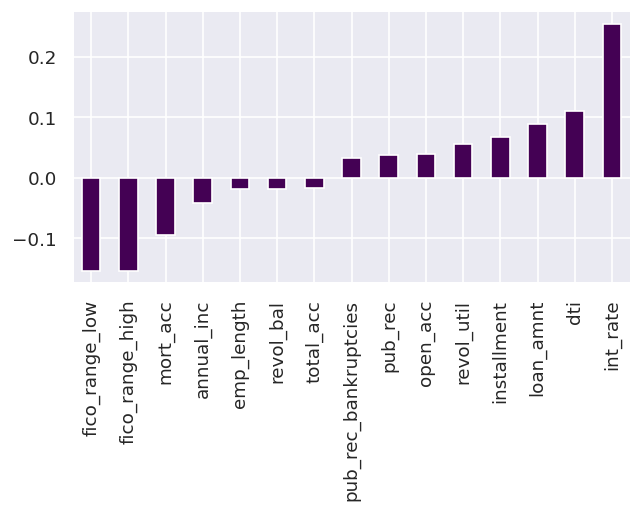

In [ ]:
plt.figure(figsize=(6,3),dpi=120)
df.corr()['loan_status'].sort_values().drop('loan_status').plot(kind='bar', cmap='viridis') # correlation with loan_status for continuous features with loan_status feature dropped
plt.xticks(rotation=90); 



In the Graph [0,0],

The no. of payments of loan is 36 months for most of the customers and the rest have 60 months. 

In 36 months, 24% of the customers are defaulting the loan, whereas in 60 months 45% of the customers are defaulting the loans. 

---
In Graph [0,1],

It is seen that as the Grade increases the Defaulters Rate also increases,
there is a linear relationship between grade and defaulters rate.

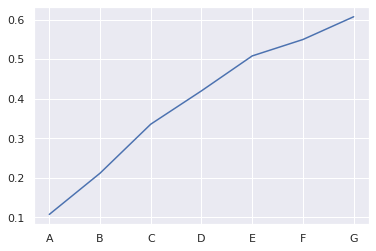

---









In Graph [0,1],

The initial listing Status consists of two types 

1.   Fractional denoted by f
2.   Whole denoted by w

The defaulters Rate is 0.32 for the the customer who were given the whole Loan amount, and the defaulters rate is 0.27 for the customers who where given loan amounts in Fractions(Installments)
.


In [ ]:
len(df[df['annual_inc'] > 250000])

9612

In [ ]:
percent_of_rows_of_customers_with_annual_inc_more_than_250000 = 9612*100/len(df) 

In [ ]:
percent_of_rows_of_customers_with_annual_inc_more_than_250000

0.9535837267742541

In [ ]:
df = df[df['annual_inc'] <= 250000]

In [ ]:
df = df[df['total_acc'] < 64]

In [ ]:
df = df[df['mort_acc'] < 11]

In [ ]:
df = df.drop(['title','emp_title'],axis =1)

In [ ]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda date: int(date[-4:]))

In [ ]:
df['revol_util'] = np.where(df['revol_util'].isnull(),df['revol_util'].median(),df['revol_util'])


In [ ]:
df['emp_length'] = np.where(df['emp_length'].isna(),0.0,df['emp_length'])

In [ ]:
df['fico'] = (df['fico_range_high'] + df['fico_range_low'])/2
df = df.drop(['fico_range_high','fico_range_low'],axis = 1)

In [ ]:
df = df.dropna().reset_index()

In [ ]:
df['loan_status'].value_counts(normalize = True)

0    0.690369
1    0.309631
Name: loan_status, dtype: float64

In [ ]:
df_copy = df.copy()

In [ ]:
target_col = pd.DataFrame(df['loan_status'])

In [ ]:
df = df.drop(['index','loan_status'],axis =1)

In [ ]:
num_col = df.select_dtypes(exclude = 'object')

In [ ]:
num_col = num_col.drop(['pub_rec_bankruptcies','open_acc','installment'],axis =1)

In [ ]:
num_col.head()

,loan_amnt,int_rate,emp_length,annual_inc,dti,earliest_cr_line,pub_rec,revol_bal,revol_util,total_acc,mort_acc,fico
0,18000.0,19.48,7.0,150000.0,9.39,2005,1.0,14052.0,40.7,27.0,2.0,667.0
1,4225.0,14.85,5.0,35000.0,15.22,2011,0.0,1058.0,24.6,6.0,0.0,727.0
2,16000.0,12.88,10.0,65000.0,18.96,1985,1.0,5157.0,54.3,20.0,0.0,677.0
3,24250.0,24.24,4.0,75000.0,20.84,2007,0.0,24799.0,65.3,21.0,2.0,662.0
4,10000.0,17.97,2.0,55000.0,35.70,2001,0.0,38623.0,78.0,28.0,6.0,687.0


In [ ]:
cat_col = df.select_dtypes(include = 'object')

In [ ]:
cat_col = cat_col.drop(['sub_grade','issue_d'],axis =1)

In [ ]:
cat_col.describe().T

,count,unique,top,freq
term,940981,2,36 months,692992
grade,940981,7,C,276788
home_ownership,940981,6,MORTGAGE,460105
verification_status,940981,3,Source Verified,355372
purpose,940981,13,debt_consolidation,554004
addr_state,940981,51,CA,136948
initial_list_status,940981,2,w,554009
application_type,940981,2,Individual,917835


In [ ]:
enc = LabelEncoder()
Cat_col = cat_col.apply(LabelEncoder().fit_transform)

In [ ]:
feature_col = pd.concat([num_col,Cat_col],axis =1)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1 , test_size = 0.2 , random_state=42)
for train_index, test_index in sss.split(feature_col, target_col):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = feature_col.iloc[train_index], feature_col.iloc[test_index]
  y_train, y_test = target_col.iloc[train_index], target_col.iloc[test_index]


TRAIN: [425965 345793 905771 ... 803017 207843 523517] TEST: [203678 646876 230273 ... 163379 624920 939557]


In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.fit_transform(X_test)  


In [ ]:
def fit_score_clf(clf,X_train,y_train,X_test,y_test, name = 'clf'):

  clf.fit(X_train,y_train)
  y_pred = clf.predict(X_test)
  clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
  clf_report['clf'] = name
    
  return clf_report

In [ ]:
def Confusion_matrix(clf):
  y_pred = clf.predict(X_test)
  plot_confusion_matrix(clf, X_test , y_test , normalize='true', cmap = 'Blues')


In [ ]:
def rocscore(clf,X_train,y_train,X_test,y_test, name = 'clf'):

  clf.fit(X_train, y_train)
  ytrain_pred = clf.predict_proba(X_train)
  print('Training roc-auc: {}'.format(roc_auc_score(y_train, ytrain_pred[:,1])))
  ytest_pred = clf.predict_proba(X_test)
  print('Test roc-auc: {}'.format(roc_auc_score(y_test, ytest_pred[:,1])))




In [ ]:
roc_dict = {}   # ROC dict for FPR and TPR  (FPR = False Positive Rate  & TPR = True Positive Rate)

def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):                                         # clf = Classifier
  fpr, tpr, thresholds = roc_curve(y_test,
                                     clf.predict_proba(X_test)[:,1],
                                     pos_label=1)
  ROC_AUC_SCORE = roc_auc_score(y_test,clf.predict_proba(X_test)[:,1])
  clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds ,'ROC_AUC_SCORE': ROC_AUC_SCORE}
    
  dict_modify[name] = clf_roc_dict

# **WITHOUT OVERSAMPLING**

# **BY HYPERPARAMETER TUNING**

**LOGISTIC REGRESSION**

In [ ]:
lr1 = LogisticRegression(penalty='l1',
                        C = 1.0,
                        solver = 'liblinear',
                        max_iter = 1000,
                        n_jobs = 2,
                        class_weight = 'balanced')

lr1_report = fit_score_clf(lr1,X_train,y_train,X_test,y_test, name = 'lr1')
lr1_report

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.806564,0.459677,0.65517,0.633120,0.699156,lr1
recall,0.658418,0.647927,0.65517,0.653173,0.655170,lr1
f1-score,0.725001,0.537804,0.65517,0.631402,0.667038,lr1
support,129925.000000,58272.000000,0.65517,188197.000000,188197.000000,lr1


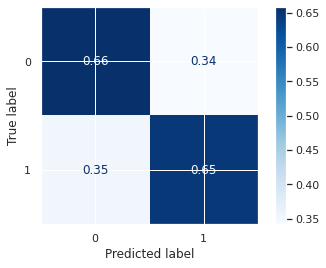

In [ ]:
Confusion_matrix(lr1)

In [ ]:
rocscore(lr1,X_train,y_train,X_test,y_test, name = 'lr1')

Training roc-auc: 0.7098542990273929
Test roc-auc: 0.7114452285075125


In [ ]:
A = pd.DataFrame(lr1.coef_).T

In [ ]:
importance_df = pd.DataFrame({
    'feature': feature_col.columns,
    'importance': abs(A[0])
}).sort_values('importance', ascending=False)

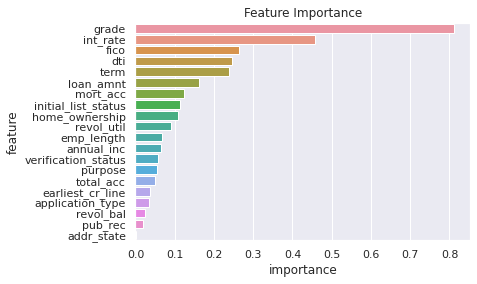

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(25), x='importance', y='feature');

In [ ]:
(lr1.coef_.round(2))

array([[ 0.16, -0.46, -0.07, -0.07,  0.25,  0.04,  0.02, -0.02, -0.09,
        -0.05, -0.12, -0.26,  0.24,  0.81,  0.11,  0.06,  0.05,  0.  ,
         0.11,  0.04]])

In [ ]:
lr1.intercept_.round(4)

array([-0.1087])

In [ ]:
modify_roc_dict(clf = lr1 ,
                y_test = y_test,
                X_test = X_test,
                name = 'Logistic_Regression1',
                dict_modify = roc_dict)

In [ ]:
RF = RandomForestClassifier(n_estimators=100,
                            criterion= 'gini',
                            n_jobs=-1, 
                            random_state = 42,
                            max_depth = 15,
                            class_weight = 'balanced')
                            
lin_RF_report = fit_score_clf(RF,X_train,y_train,X_test,y_test, name = 'Random_Forest')
lin_RF_report


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.814041,0.488716,0.681148,0.651378,0.713309,Random_Forest
recall,0.697472,0.644752,0.681148,0.671112,0.681148,Random_Forest
f1-score,0.751261,0.555994,0.681148,0.653627,0.690800,Random_Forest
support,129925.000000,58272.000000,0.681148,188197.000000,188197.000000,Random_Forest


In [ ]:
importance_df = pd.DataFrame({
    'feature': feature_col.columns,
    'importance': RF.feature_importances_
}).sort_values('importance', ascending=False)

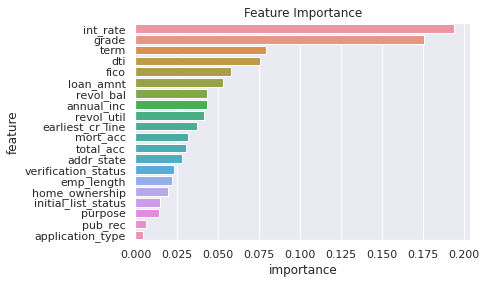

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(21), x='importance', y='feature');

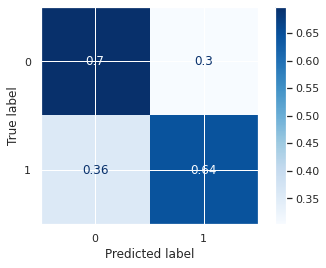

In [ ]:
Confusion_matrix(RF)

In [ ]:
rocscore(RF,X_train,y_train,X_test,y_test, name = 'RF')

Training roc-auc: 1.0
Test roc-auc: 0.737374249926324


In [ ]:
modify_roc_dict(clf = RF ,
                y_test = y_test,
                X_test = X_test,
                name = 'Random Forest',
                dict_modify = roc_dict)

In [ ]:
xgb = xgb.XGBClassifier(n_estimators=300,
                        learning_rate = 1,
                            subsample=0.9,
                            n_jobs=-1,
                        max_depth=5)

xgb_report = fit_score_clf(xgb, X_train, y_train, X_test,y_test, name='xgb')
xgb_report

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.754804,0.548050,0.710814,0.651427,0.690786,xgb
recall,0.860712,0.376596,0.710814,0.618654,0.710814,xgb
f1-score,0.804287,0.446427,0.710814,0.625357,0.693481,xgb
support,129925.000000,58272.000000,0.710814,188197.000000,188197.000000,xgb


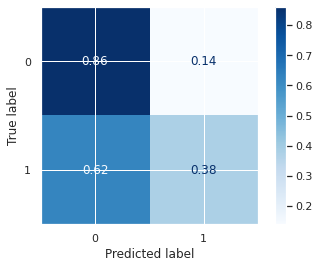

In [ ]:
Confusion_matrix(xgb)

In [ ]:
modify_roc_dict(clf = xgb ,
                y_test = y_test,
                X_test = X_test,
                name = 'XGB',
                dict_modify = roc_dict)

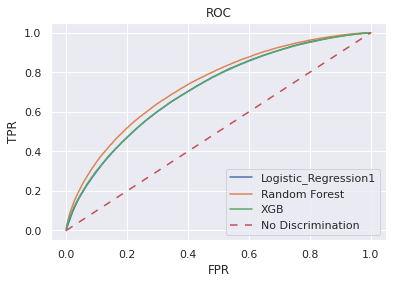

In [ ]:
for key in roc_dict:
    clf = roc_dict[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.legend()
plt.show()

# **WITH OVERSAMPLING**

In [ ]:
df1 = df_copy[df_copy['loan_status'] == 1]

In [ ]:
DF = pd.concat([df_copy,df1],axis = 0)

In [ ]:
DF = DF.dropna().reset_index()

In [ ]:
Target_col = pd.DataFrame(DF['loan_status'])

In [ ]:
DF = DF.drop(['index','loan_status','level_0'],axis =1)

In [ ]:
Num_col = DF.select_dtypes(exclude = 'object')

In [ ]:
Num_col = Num_col.drop(['pub_rec_bankruptcies','open_acc','installment'],axis =1)

In [ ]:
CAT_col = DF.select_dtypes(include = 'object')

In [ ]:
CAT_col = CAT_col.drop(['sub_grade','issue_d'],axis =1)

In [ ]:
enc = LabelEncoder()
CAT_COL = CAT_col.apply(LabelEncoder().fit_transform)

In [ ]:
Feature_col = pd.concat([Num_col,CAT_COL],axis = 1)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1 , test_size = 0.2 , random_state=42)
for train_index, test_index in sss.split(Feature_col, Target_col):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train1, X_test1 = Feature_col.iloc[train_index], Feature_col.iloc[test_index]
  y_train1, y_test1 = Target_col.iloc[train_index], Target_col.iloc[test_index]


TRAIN: [ 923522  120806  844409 ...  440421 1009402  236286] TEST: [320557 374792 723167 ... 242876 442627 260522]


In [ ]:
ss = StandardScaler()
X_train1 = ss.fit_transform(X_train1)
X_test1 = ss.fit_transform(X_test1)  


In [ ]:
def Confusion_matrix(clf):
  y_pred = clf.predict(X_test1)
  plot_confusion_matrix(clf, X_test1 , y_test1 , normalize='true', cmap = 'Blues')


In [ ]:
roc_dict1 = {}   # ROC dict for FPR and TPR  (FPR = False Positive Rate  & TPR = True Positive Rate)

def modify_roc_dict(clf, y_test, X_test, name ,dict_modify):                                         # clf = Classifier
  fpr, tpr, thresholds = roc_curve(y_test1,
                                     clf.predict_proba(X_test1)[:,1],
                                     pos_label=1)
  ROC_AUC_SCORE = roc_auc_score(y_test,clf.predict_proba(X_test1)[:,1])
  clf_roc_dict = {'fpr':fpr, 'tpr': tpr, 'thresholds': thresholds ,'ROC_AUC_SCORE': ROC_AUC_SCORE}
    
  dict_modify[name] = clf_roc_dict

In [ ]:
lr2 = LogisticRegression(penalty='l1',
                        C = 1.0,
                        solver = 'liblinear',
                        max_iter = 1000,
                        n_jobs = 2)

lr2_report = fit_score_clf(lr2,X_train1,y_train1,X_test1,y_test1, name = 'lr2')
lr2_report

,0,1,accuracy,macro avg,weighted avg,clf
precision,0.657847,0.644247,0.651963,0.651047,0.651416,lr2
recall,0.708024,0.589465,0.651963,0.648744,0.651963,lr2
f1-score,0.682014,0.615640,0.651963,0.648827,0.650629,lr2
support,129925.000000,116543.000000,0.651963,246468.000000,246468.000000,lr2


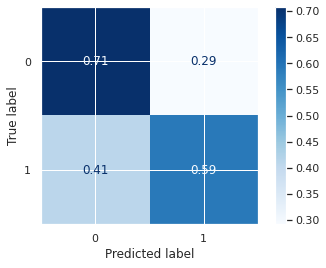

In [ ]:
Confusion_matrix(lr2)

In [ ]:
A = pd.DataFrame(lr2.coef_).T

In [ ]:
importance_df = pd.DataFrame({
    'feature': Feature_col.columns,
    'importance': abs(A[0])
}).sort_values('importance', ascending=False)

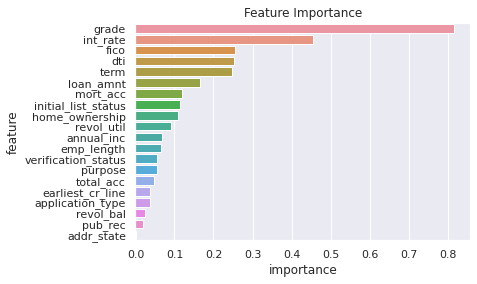

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(25), x='importance', y='feature');

In [ ]:
(lr2.coef_.round(2))

array([[ 0.17, -0.45, -0.07, -0.07,  0.25,  0.04,  0.02, -0.02, -0.09,
        -0.05, -0.12, -0.26,  0.25,  0.82,  0.11,  0.05,  0.05,  0.  ,
         0.11,  0.04]])

In [ ]:
lr2.intercept_.round(4)

array([-0.1191])

In [ ]:
modify_roc_dict(clf = lr2 ,
                y_test = y_test1,
                X_test = X_test1,
                name = 'Logistic_Regression2',
                dict_modify = roc_dict1)

In [ ]:
RF1 = RandomForestClassifier(n_estimators=100,
                            criterion= 'gini',
                            n_jobs=-1, 
                            random_state = 42)
                            
lin_RF1_report = fit_score_clf(RF1,X_train1,y_train1,X_test1,y_test1, name = 'Random_Forest1')
lin_RF1_report


,0,1,accuracy,macro avg,weighted avg,clf
precision,0.897162,0.825526,0.860485,0.861344,0.863289,Random_Forest1
recall,0.830541,0.893867,0.860485,0.862204,0.860485,Random_Forest1
f1-score,0.862567,0.858339,0.860485,0.860453,0.860568,Random_Forest1
support,129925.000000,116543.000000,0.860485,246468.000000,246468.000000,Random_Forest1


In [ ]:
importance_df = pd.DataFrame({
    'feature': Feature_col.columns,
    'importance': RF1.feature_importances_
}).sort_values('importance', ascending=False)

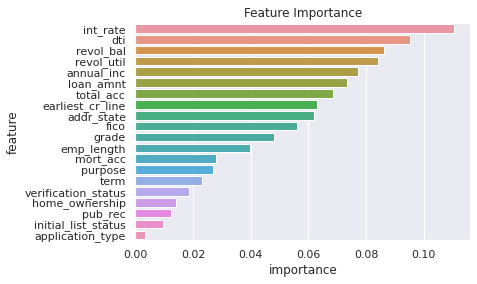

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(21), x='importance', y='feature');

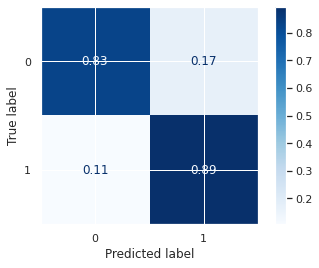

In [ ]:
Confusion_matrix(RF1)

In [ ]:
modify_roc_dict(clf = RF1 ,
                y_test = y_test1,
                X_test = X_test1,
                name = 'Random Forest1',
                dict_modify = roc_dict1)

In [ ]:
xgb1 = xgb.XGBClassifier(n_estimators=300,
                            subsample=0.9,
                            n_jobs=-1)
xgb1.fit(X_train1,y_train1)
y_pred = xgb1.predict(X_test1)
xgb1_report = pd.DataFrame(classification_report(y_test1, y_pred, output_dict=True))


In [ ]:
xgb1_report

,0,1,accuracy,macro avg,weighted avg
precision,0.691805,0.684900,0.688787,0.688353,0.688540
recall,0.738726,0.633114,0.688787,0.685920,0.688787
f1-score,0.714496,0.657990,0.688787,0.686243,0.687777
support,129925.000000,116543.000000,0.688787,246468.000000,246468.000000


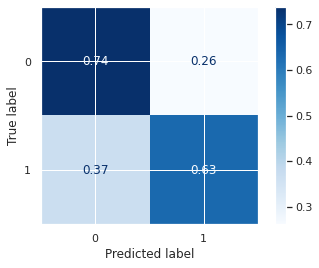

In [ ]:
y_pred = xgb1.predict(X_test1)
plot_confusion_matrix(xgb1, X_test1 , y_test1 , normalize='true', cmap = 'Blues')


In [ ]:
importance_df = pd.DataFrame({
    'feature': Feature_col.columns,
    'importance': xgb1.feature_importances_
}).sort_values('importance', ascending=False)

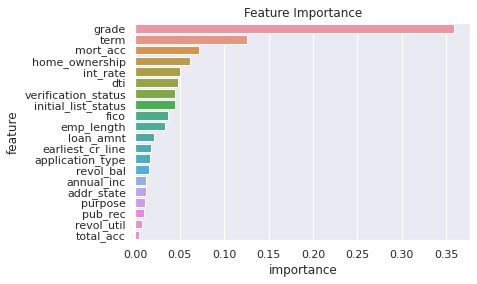

In [ ]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(21), x='importance', y='feature');

In [ ]:
modify_roc_dict(clf = xgb1 ,
                y_test = y_test1,
                X_test = X_test1,
                name = 'XGB1',
                dict_modify = roc_dict1)

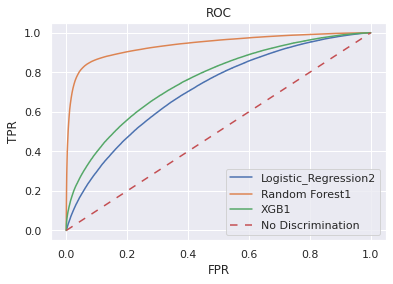

In [ ]:
for key in roc_dict1:
    clf = roc_dict1[key]
    plt.plot(clf['fpr'], clf['tpr'], label=key)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.legend()
plt.show()